/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model with best parameters saved as xgb_prakruthi_model_best_params.pkl
Label encoder saved as label_encoder.pkl

XGBoost Accuracy: 0.8852459016393442

Classification Report:
                precision    recall  f1-score   support

       Kaphaj       0.89      1.00      0.94         8
Kaphaj-Pittaj       1.00      0.62      0.77         8
       Pittaj       0.75      1.00      0.86         9
Pittaj-Kaphaj       0.67      0.67      0.67         9
 Pittaj-Vataj       1.00      1.00      1.00         9
        Vataj       1.00      0.89      0.94         9
 Vataj-Pittaj       1.00      1.00      1.00         9

     accuracy                           0.89        61
    macro avg       0.90      0.88      0.88        61
 weighted avg       0.90      0.89      0.88        61



<ipython-input-10-bfdc5a0ee0df>:93: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-bfdc5a0ee0df>:94: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig('feature_importance.png')  # Save the figure
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


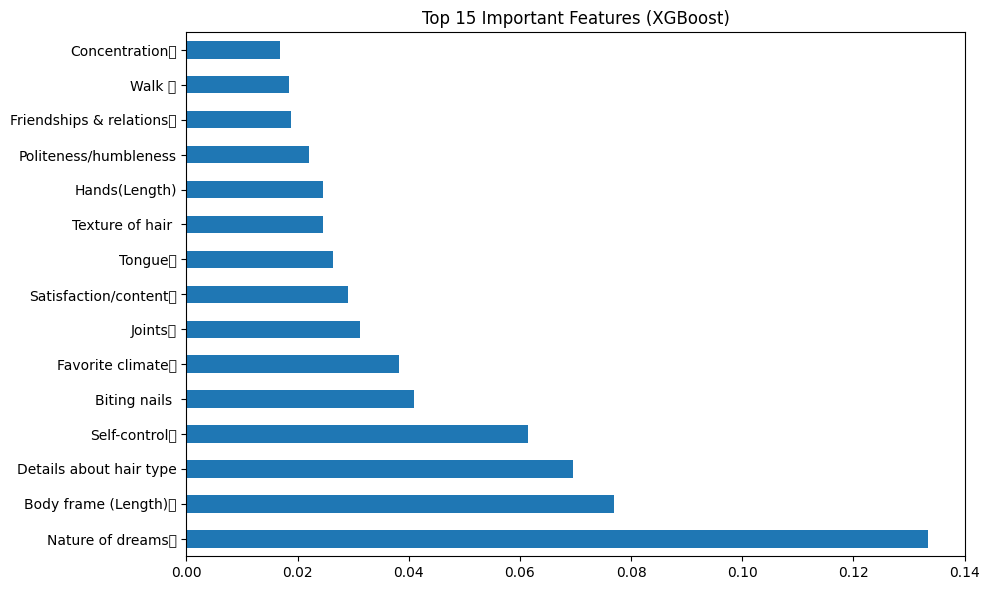

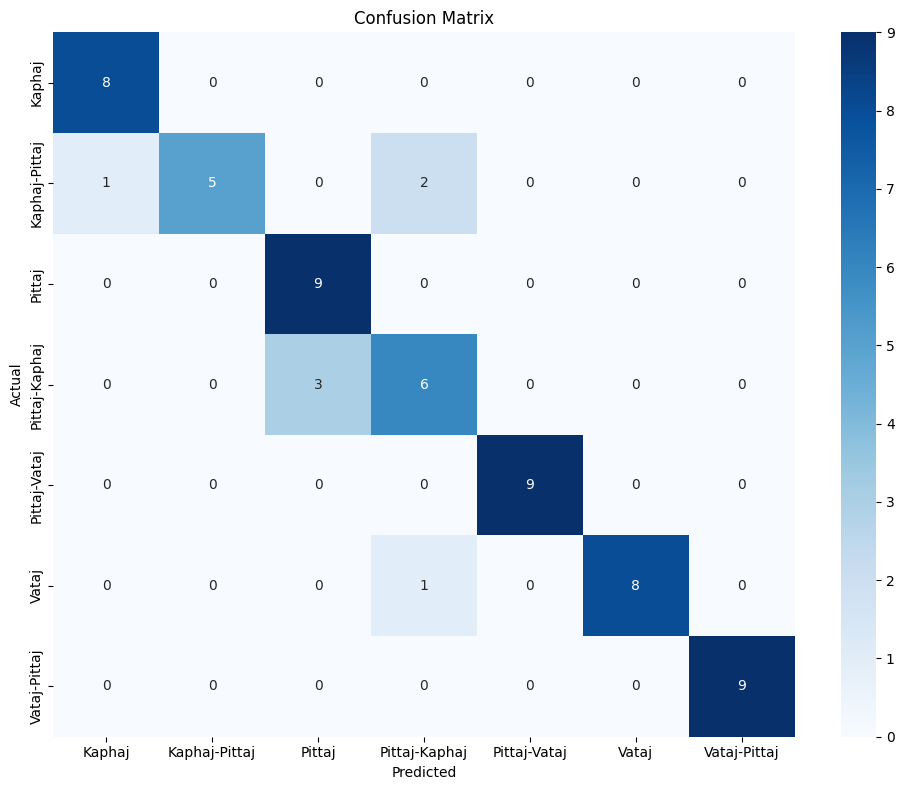

In [10]:
# ===================== LOAD AND CLEAN DATA ===================== #
datacsv = pd.read_csv("https://raw.githubusercontent.com/SebastianBenjamin/MLDataSets/refs/heads/main/Prakriti%20Nishchitikaran%20Questionnaire_data.csv")

# Drop unwanted columns
cols_to_drop = ["Name", "Username", "Age group", "City", "Are you diabetic?",
                "Do you have high/low BP problem?", "Generosity  ", "Stealing/hiding/plagiarism ",
                "Jealous/strife ", "Stiff body", "Never surrender ", "Forgiveness\t", "Enmity"]
datacsv.drop(columns=cols_to_drop, inplace=True)
datacsv.dropna(inplace=True)
datacsv["Prakruthi"] = ""

# Prakruthi assignment function
def prakruthiNishchikaran(row):
    valueArray = list(row)
    countOfValues = {'P': 0, 'V': 0, 'K': 0}
    for val in valueArray:
        match int(val):
            case 1: countOfValues['P'] += 1
            case 2: countOfValues['V'] += 1
            case 3: countOfValues['K'] += 1
    P, V, K = countOfValues['P'], countOfValues['V'], countOfValues['K']
    if P >= 27: return "Pittaj"
    elif V >= 27: return "Vataj"
    elif K >= 27: return "Kaphaj"
    elif P > K > V: return "Pittaj-Kaphaj"
    elif P >= K > V: return "Pittaj-Vataj"
    elif V >= K > P: return "Vataj-Pittaj"
    elif K > P > V: return "Kaphaj-Pittaj"
    else: return "NA"

# Assign Prakruthi
for index, row in datacsv.iterrows():
    prak = prakruthiNishchikaran(row.drop('Prakruthi'))
    datacsv.at[index, 'Prakruthi'] = prak

# Remove "NA" labels
datacsv = datacsv[datacsv['Prakruthi'] != "NA"]

# ===================== FEATURES & TARGET ===================== #
X = datacsv.drop("Prakruthi", axis=1)
y = datacsv["Prakruthi"]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# ===================== BUILD MODEL WITH BEST PARAMETERS ===================== #
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.2,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 100,
    'subsample': 0.8
}

# Create and train the model with best parameters
best_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(set(y_resampled)),
    use_label_encoder=False,
    eval_metric="mlogloss",
    **best_params,
    random_state=42
)

best_xgb.fit(X_train, y_train)

# Save the model to a file
joblib.dump(best_xgb, 'xgb_prakruthi_model.pkl')
print("Model with best parameters saved as xgb_prakruthi_model_best_params.pkl")

# Save the label encoder
joblib.dump(le, 'label_encoder.pkl')
print("Label encoder saved as label_encoder.pkl")

# ===================== EVALUATION ===================== #
y_pred = best_xgb.predict(X_test)
print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Plotting feature importance
plt.figure(figsize=(10,6))
pd.Series(best_xgb.feature_importances_, index=X.columns).nlargest(15).plot(kind='barh')
plt.title("Top 15 Important Features (XGBoost)")
plt.tight_layout()
plt.savefig('feature_importance.png')  # Save the figure
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')  # Save the figure
plt.show()


In [11]:
datacsv.columns


Index(['Skin color', 'Skin texture', 'Details about hair type',
       'Texture of hair ', 'My hairs are', 'Hair falling tendency\t', 'Eyes\t',
       'My eyes  eye balls are', 'Physique\t', 'Veins\t',
       'Usual body temperature \t', 'Teeth \t', 'Is your lips\t',
       'Hands(Length)', 'Body hair\t', 'Joints\t', 'Chest\t', 'Tongue\t',
       'Body frame (Length)\t', 'Body frame (Breadth)\t',
       'Bodyweight changes\t', 'Style of speaking\t', 'Voice \t', 'Walk \t',
       'Appetite \t ', 'Intensity of hunger\t', 'Favorite climate\t',
       'Stamina\t', 'Tastes, I like most', 'Eagerness about drinking water',
       'Frequency of liquid intake\t', 'Sleep\t', 'Quantity of sweat\t',
       'Emotion\t', 'Intellect\t', 'Grasping\t', 'Concentration\t', 'Memory\t',
       'Temperament\t', 'Patience\t', 'Satisfaction/content\t',
       'While making decisions\t', 'Activities\t', 'Nature of dreams\t',
       'Friendships & relations\t', 'Faith in God\t', 'Self-control\t',
       'Gratef

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model with best parameters saved as xgb_prakruthi_model_best_params.pkl
Label encoder saved as label_encoder.pkl

XGBoost Accuracy: 0.8852459016393442

Classification Report:
                precision    recall  f1-score   support

       Kaphaj       0.89      1.00      0.94         8
Kaphaj-Pittaj       1.00      0.62      0.77         8
       Pittaj       0.75      1.00      0.86         9
Pittaj-Kaphaj       0.67      0.67      0.67         9
 Pittaj-Vataj       1.00      1.00      1.00         9
        Vataj       1.00      0.89      0.94         9
 Vataj-Pittaj       1.00      1.00      1.00         9

     accuracy                           0.89        61
    macro avg       0.90      0.88      0.88        61
 weighted avg       0.90      0.89      0.88        61



<ipython-input-7-737427ebc97b>:93: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-7-737427ebc97b>:94: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig('feature_importance.png')  # Save the figure
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


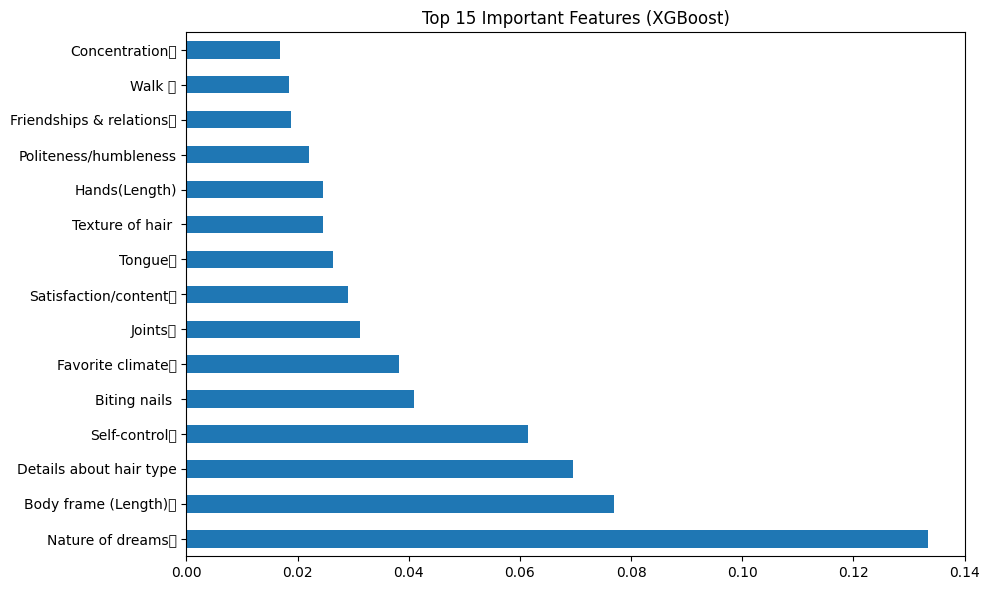

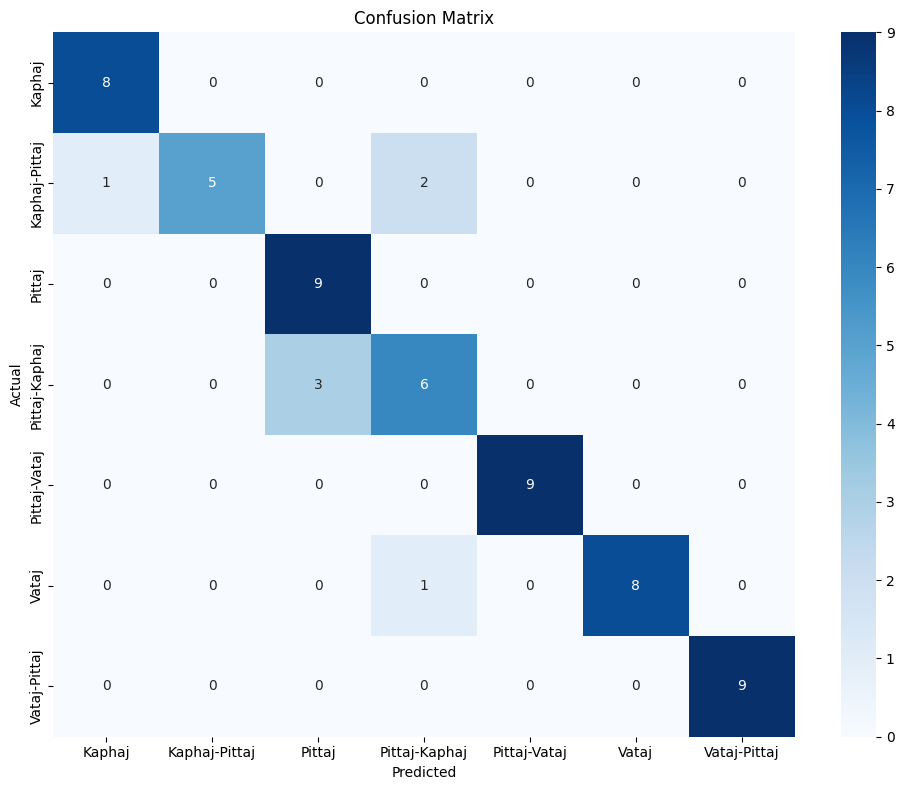